In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 23.5 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 636 kB 53.5 MB/s 
     |████████████████████████████████| 895 kB 64.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=849ff5f915922a616be0be38d15886d76b9cc4628cc2c16065ad32be2ab3056e
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
#import pyLDAvis
#import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 85 kB 3.3 MB/s 
     |████████████████████████████████| 2.6 MB 54.1 MB/s 
     |████████████████████████████████| 1.2 MB 46.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 3.3 MB 55.6 MB/s 
     |████████████████████████████████| 636 kB 49.0 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=679eff16df97c49be0eb8e3fef841fadac59d5f89b60f77885c3406aa7b2d53f
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
data = pd.read_csv('/content/metadata.csv',usecols=['cord_uid','source_x','title','license','publish_time','abstract','authors','journal','url'],error_bad_lines=False, engine="python")

Skipping line 91638: unexpected end of data


In [ ]:
data.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url
0,ug7v899j,PMC,Clinical features of culture-proven Mycoplasma...,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,02tnwd4m,PMC,Nitric oxide: a pro-inflammatory mediator in l...,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
2,ejv2xln0,PMC,Surfactant protein-D and pulmonary host defense,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
3,2b73a28n,PMC,Role of endothelin-1 in lung disease,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
4,9785vg6d,PMC,Gene expression in epithelial cells in respons...,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [ ]:
data = data[data.publish_time=='2021']
print(f'There are {len(data)} articles published in 2021')

There are 669 articles published in 2021


In [ ]:
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 170 articles with missing abstract


In [ ]:
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 0 articles with duplicate abstract


Warning: Although the articles with duplicated abstracts are dropped, there still exist some articles with meaningless abstracts. The cleaning strategy here only weakens the effects of those meaningless abstracts.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())


data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
15326,ilsrad9a,PMC,Tomographic findings in bronchial atresia,cc-by,objective: to evaluate computed tomography (ct...,2021,"Puglia, Elazir Barbosa Mota Di; Rodrigues, Ros...",Radiol Bras,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[objective, evaluate, computed, tomography, ct..."
16467,30svjjwj,PMC,In Vitro Antileishmanial Effects of Saffron Co...,cc-by-nc,background: due to numerous side effects of co...,2021,"RANJBAR, Reza; SHAYANFAR, Peyman; MANIATI, Mah...",Iran J Parasitol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[background, due, numerous, side, effects, com..."
17518,nn5v2q3e,PMC,Is This Science? Students’ Experiences of Fail...,cc-by-nc-sa,course-based undergraduate research experience...,2021,"Goodwin, Emma C.; Anokhin, Vladimir; Gray, Mac...",CBE Life Sci Educ,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[undergraduate, research, experiences, cures, ..."
44635,36budc48,PMC,Assessment of prevalence of Anxiety in adult p...,cc-by,objective: to develop an indigenous anxiety sc...,2021,"Bano, Zaqia; Ejaz, Maria; Ahmad, Ishtiaq",Pak J Med Sci,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[objective, develop, indigenous, anxiety, scal..."
48357,31sylkes,PMC,Italy,no-cc,excavations at isernia have uncovered remains ...,2021,NaN,The Statesman&#x02019;s Yearbook 2021,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[excavations, isernia, uncovered, remains, pal..."


In [ ]:
data.reset_index(drop=True,inplace=True)

Here I create inverted index. Inverted index is a fundamental technology used commonly in search engine . Inverted index assigns each word with a list of document id and it helps retrieve the articles with keyword matching fastly. For example {'patient':[1,3,6]} means that the word patient occurs in the second,fourth and sixth document in the corpus

In [ ]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 8924 unique words in inverted index


Article Matching and Deep Cleaning

In [ ]:
keywords_risk = ['risk','risky','risks','risked','risking']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 89 articles related to risk


In [ ]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
15,vci3nd6x,Medline,Health Information National Trends Survey (HIN...,unk,as an initiative of the national cancer instit...,2021,"Winston, Sarah",Medical reference services quarterly,https://doi.org/10.1080/02763869.2021.1912575;...,"[initiative, national, cancer, institute, nci,..."
21,g927opm0,Medline,Internet of Things (IoT) enabled healthcare he...,unk,background/objectives the internet of things (...,2021,"Javaid, Mohd; Khan, Ibrahim Haleem",Journal of oral biology and craniofacial research,https://doi.org/10.1016/j.jobcr.2021.01.015; h...,"[internet, things, iot, create, disruptive, in..."
23,rn2mdkit,Medline,Determining a target SpO2 to maintain PaO2 wit...,unk,objective in the context of an ongoing debate ...,2021,"Röttgering, Jantine G; de Man, Angelique M E; ...",PloS one,https://doi.org/10.1371/journal.pone.0250740; ...,"[objective, context, ongoing, debate, potentia..."
33,qaznxkeu,Medline,Case Report: Bowel Occlusion Following the Use...,unk,introduction: a high level of surgical ability...,2021,"Stabile, Guglielmo; Romano, Federico; De Santo...",Frontiers in surgery,https://doi.org/10.3389/fsurg.2021.626505; htt...,"[introduction, high, level, surgical, ability,..."
36,a1p1vnh1,Medline,Early Life Stage Assays in Zebrafish.,unk,fish embryo toxicity (fet) test using zebrafis...,2021,"Abe, Flávia Renata; Accoroni, Klaus Alvaro Gue...",Methods in molecular biology,https://doi.org/10.1007/978-1-0716-1091-6_7; h...,"[fish, embryo, toxicity, fet, test, using, zeb..."


For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words.

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out  

Text(0.5, 1.0, 'Word Cloud: Articles Related to Risk Factor')

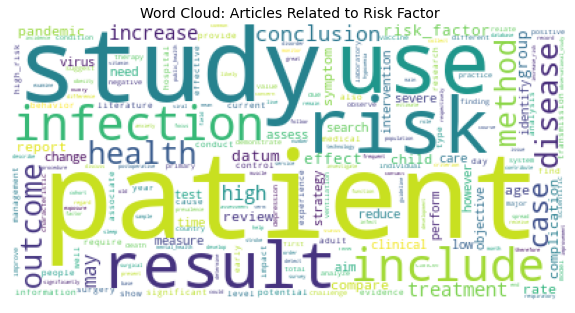

In [ ]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_tokens']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])
#trigram = Phrases(list(risk_article['Phrase_Lemma_Tokens']), min_count=5)
#risk_article['Phrase_Lemma_Tokens'] = risk_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Risk Factor' ,fontsize=14)

Words or phrases like 'risk', 'result', 'patient', 'infection', 'disease', 'study' occur frequently in this corpus.

**Topic Extraction I: LDA**

For topic modeling in python, LDA model are available and fast to implement with the help of either two libraries (sklearn and genism).

sklearn LDA pipeline: CounterVectorizer + LatentDirichletAllocation + GridSearchCV

gensim pipeline: Dictionary + doc2bow + LdaModel + CoherenceModel

100%|██████████| 8/8 [00:16<00:00,  2.09s/it]

Topic number selection took 16.75243616104126 seconds


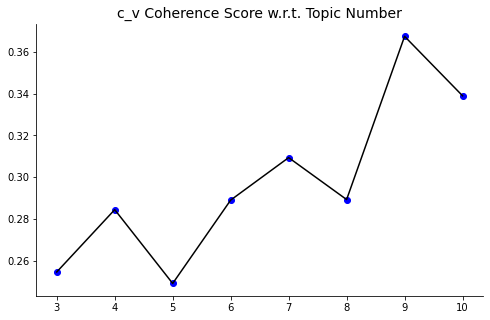

In [ ]:
##https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))
##eliminate rare and frequent tokens
#id2token_risk_article.filter_extremes(no_below=2, no_above=0.8, 
#                                       keep_tokens=['smoke','smoking','smoker'])
corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
    #cm = CoherenceModel(model=lda_model, corpus=corpus_smoke_article, coherence='u_mass')
    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

The higher the c_v coherence score is, the more suitable the topic number should be. However, the coherence score will vary if we run the iteration different times. Hence, I choose 6 as the topic number for analysis.

In [ ]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -7.464924738042608


Word per Topic

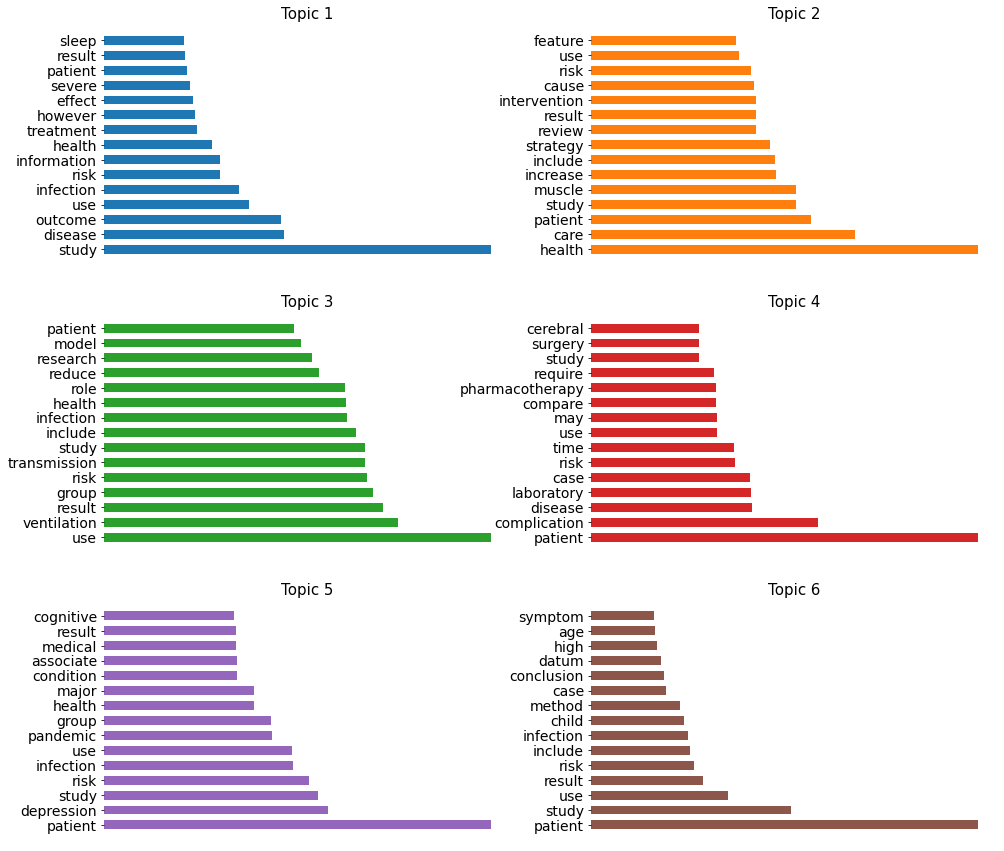

In [ ]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

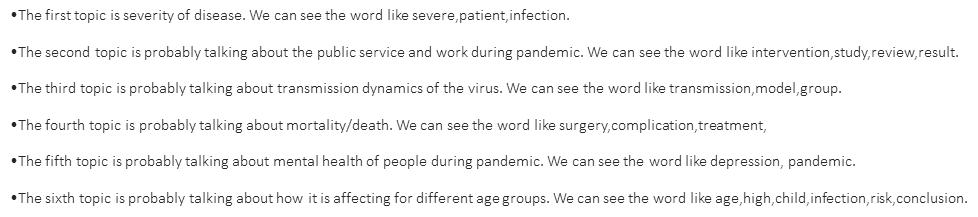

In [ ]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

NameError: ignored

Topic per Document

In [ ]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

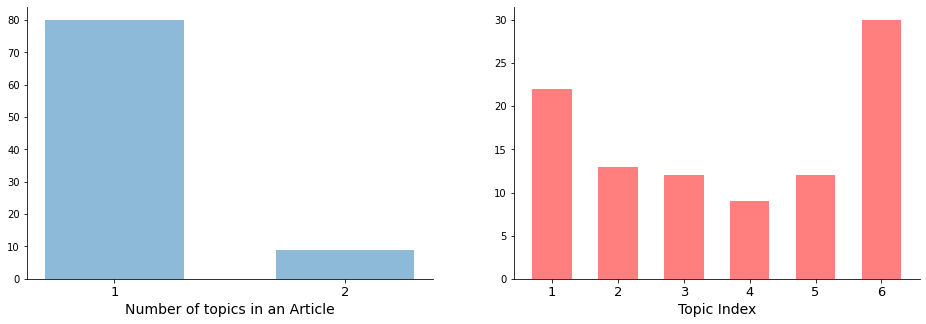

In [ ]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

The left figure shows that there are very few articles cover all the six topics or only one topic.
The right figure shows that occurence frequencies of topics are very close

In [ ]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5
0,0.000000,0.0,0.0,0.000000,0.985283,0.000000
1,0.995064,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.000000,0.000000,0.993662
3,0.000000,0.0,0.0,0.993459,0.000000,0.000000
4,0.988838,0.0,0.0,0.000000,0.000000,0.000000


In [ ]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease', 
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

The label of each article is decided by the topic with highest probability. According to the potential risk factors that Task 2 mentions and the topic inference acquired from the word-per-topic part, I lable each topic with some 'real ideas'.

As we can see from the figure, there is not too much overlap between documents of different clusters(topics) but the clusters are very close with each other.

**Why Choose T-SNE?**

'T-SNE gives the impression that it has classified the data by bringing it to two-dimensions but in reality, it doesn’t reduce the dimensions. It is a visualizer, which tells how each class is distributed and is there any overlap between them'. An intuition of T-SNE from the article on Medium: PCA vs LDA vs T-SNE — Let’s Understand the difference between them

**Topic Extraction II: SentenceBert + K-Means Clustering + TF-IDF**

Embedding Texts with SentenceBert

In [ ]:
sbert_model = SentenceTransformer('stsb-distilroberta-base-v2',device='cuda')
risk_sentences = list(risk_article['Lemma_Tokens'].apply(lambda x: ' '.join(x)))


In [ ]:
sentence_embeddings = sbert_model.encode(risk_sentences, 
                                         convert_to_numpy=True,
                                         show_progress_bar=True)

In [ ]:
print(f'The shape of each embedding sentence: {sentence_embeddings[0].shape}')

The shape of each embedding sentence: (768,)


**Clustering Documents with K-Means Clustering**

In [ ]:
num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters,
                          n_init=10,
                          max_iter=300,
                          tol=1e-4,
                          random_state=98)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

In [ ]:
df_docs = pd.DataFrame(risk_sentences,columns=['Doc'])
df_docs['Topic'] = cluster_assignment
df_docs['Doc_ID'] = range(len(df_docs))
docs_per_topic = df_docs.groupby(['Topic'],as_index=False).agg({'Doc':' '.join})
docs_per_topic

,Topic,Doc
0,0,human papilloma virus hpv vaccine world first ...
1,1,always detect virus may due difference sensiti...
2,2,internet thing iot create thus nee study diffe...
3,3,objective context ongoing debate potential ris...
4,4,characterize population old adult socioeconomi...
5,5,survey hint recur national survey assess acces...


**Extract Important Words in Topics with c-TF-IDF**
Thanks to this amazing [article](
  https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) from Medium . The author of it invented a modified TF-IDF alogirhtm called 'class-based variant of TF-IDF' to help extract the topics from clustered documents. If you find it interesting, do not forget to clap for that article :)

add Codeadd Markdown

In [ ]:
def c_TF_IDF(documents, m, ngram_range=(1, 2), min_df=3):
    bow = CountVectorizer(ngram_range=ngram_range, 
                          stop_words="english",
                          min_df = min_df,)
    bow.fit(documents)
    bow_matrix = bow.transform(documents).toarray()
    w = np.sum(bow_matrix,axis=1)
    tf = np.divide(bow_matrix.T, w)
    sum_t = np.sum(bow_matrix,axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, bow

c_tf_idf, bow = c_TF_IDF(docs_per_topic.Doc.values,m=len(risk_sentences))
print(f'The shape of cluster tf-idf matrix is {c_tf_idf.shape}')

The shape of cluster tf-idf matrix is (442, 6)


In [ ]:
def extract_top_n_words_per_topic(tf_idf, bow, docs_per_topic, n=20):
    words = bow.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {}
    for i,label in enumerate(labels):
        for j in indices[i]:
            if label not in top_n_words:
                top_n_words[label] = [(words[j],tf_idf_transposed[i][j])]
            else:
                top_n_words[label].append((words[j],tf_idf_transposed[i][j]))
        top_n_words[label] = top_n_words[label][::-1]
    
    return top_n_words

top_n_words = extract_top_n_words_per_topic(c_tf_idf,bow,docs_per_topic)
#print('Top ten words in topic 1 are:')
#pprint.pprint(top_n_words[0][:20])

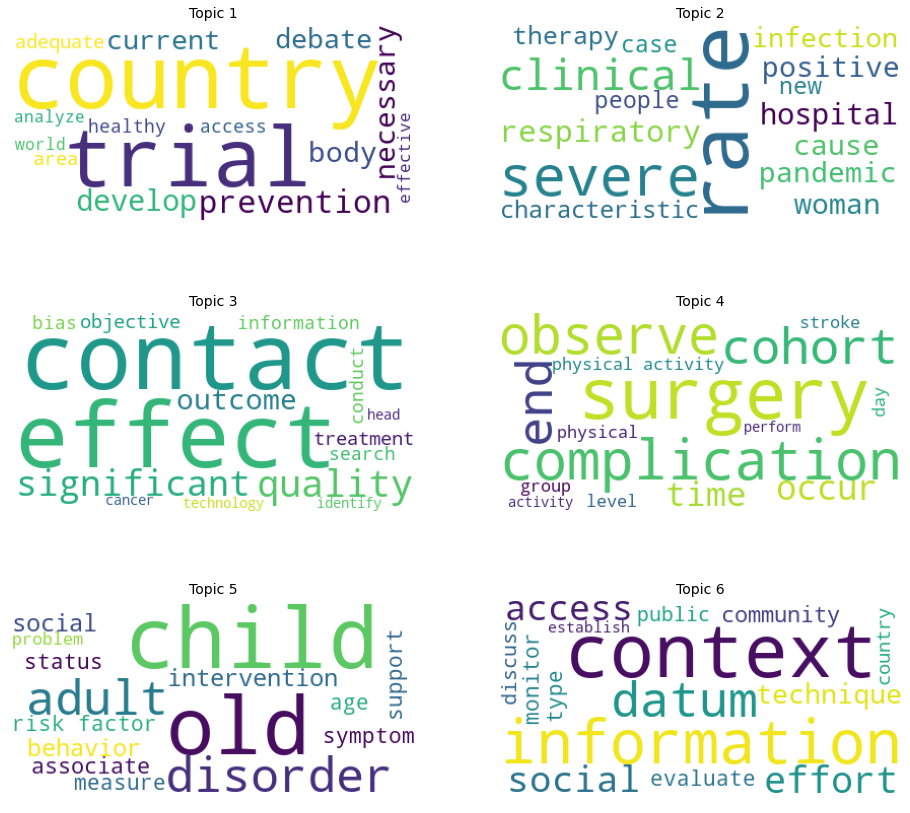

In [ ]:
fig = plt.figure(figsize=(16,15))
for label,word_prob_pairs in top_n_words.items():
    top_15_words_prob_pairs = dict(word_prob_pairs[:15])
    #probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    ax= fig.add_subplot(3,2,label+1)
    wcloud = wordcloud.WordCloud(background_color='white')
    wcloud.generate_from_frequencies(top_15_words_prob_pairs)
    ax.imshow(wcloud)
    for pos in ['left','right','top','bottom']:
        ax.spines[pos].set_color(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Topic {label+1}' ,fontsize=14)

The first topic is similar with topic 4 generated by LDA, talking about the transmission dynamic of the virus.
The second topic is similar with topic 6 generated by LDA, talking about the death
The third topic is similar with topic 3 generated by LDA, but seems more specific here, talking about one of the severe symptoms: respiratory .
The fourth topic is similar with topic 5 generated by LDA, but seems more specific here, talking about one of the public service: healthcare service.
The fifth topic is similar with topic 2 generated by LDA, but seems more specific here, talking about negative emotions like anxiety and distree.
The sixth topic is probably similar with topic 1 generated by LDA, talking about the treatment methods.

**Dimension Reduction with AutoEncoder**

I use this [blog](https://blog.keras.io/building-autoencoders-in-keras.html) as a guidance to build the autoencoder

In [ ]:
ENCODING_DIM = 32
input_embedding = tf.keras.layers.Input(shape=(sentence_embeddings.shape[1],))
encoded = tf.keras.layers.Dense(128,activation='relu')(input_embedding)
encoded = tf.keras.layers.Dense(64,activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM,activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(sentence_embeddings.shape[1], activation='linear')(decoded)

autoencoder = tf.keras.models.Model(input_embedding, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(sentence_embeddings, 
                sentence_embeddings, 
                epochs=500, 
                batch_size=128, 
                shuffle=True,)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.2983
Epoch 2/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2910
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2872
Epoch 4/500
1/1 [==============================] - 0s 4ms/step - loss: 0.2813
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2724
Epoch 6/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2606
Epoch 7/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2470
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2341
Epoch 9/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2246
Epoch 10/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2161
Epoch 11/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2057
Epoch 12/500
1/1 [==============================] - 0s 13ms/step - loss: 0.1955
Epoch 13/500
1/1 [==============================] - 0s 5ms/st

In [ ]:
encoder = tf.keras.models.Model(input_embedding,encoded)
encoded_sentence_embeddings = encoder.predict(sentence_embeddings)

**Document Clustering Visualization: Raw Embedding vs Dimension Reduction**

In [ ]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
#embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)
embedding_matrix = tSNE.fit_transform(sentence_embeddings)

df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['topic_idx'] =  cluster_assignment
df_embedding['color'] = df_embedding['topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Transmission of Virus', 1: 'Death', 2: 'Severe Respiratory Symdrone', 
                  3: 'Healthcare Service', 4: 'Mental Health', 5:'Treatment methods'}
df_embedding['label'] = df_embedding['topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of Documents: Raw Embedding', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

In [ ]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
#embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)
embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)

df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['topic_idx'] =  cluster_assignment
df_embedding['color'] = df_embedding['topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Transmission of Virus', 1: 'Death', 2: 'Severe Respiratory Symdrone', 
                  3: 'Healthcare Service', 4: 'Mental Health', 5:'Treatment methods'}
df_embedding['label'] = df_embedding['topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of Documents: Embeddings after Dimension Reduction', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

**Conclusion**

To sum up, the topics extracted from these two methods are similar, but the topics from the second method are more specific.


LDA is always a traditional and go-to algorithm for topic analysis. You can extract real ideas from topics and cluster documents based on topics easily with this algorithm. The advantage of LDA is that you can get relatively clear boundaries when clustering the documents while the disadvantage of LDA is that the real ideas from topics are somewhat ambiguous because it is not easy to tune the hyparameters of this unsupervised learning algorithm.



Bert and its modified versions nowadays outperform everything and achieve state-of-art results in all kinds of NLP tasks. Hence, SentenceBert can give very good representation of the documents. The advantage of the second method is that the real ideas from topics are more meaningful and interpretable while the disadvantage of it is that the decision boundary of documents clustering is not clear.

